In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

from model.base_intensity import ConstantBaseIntensity, SineBaseIntensity
from model.impact_function import ConstantImpactFunction
from model.kernels import ExponentialKernel
from model.mark_density import TextualMarkDensity
from model.source_identify_model import SourceIdentifyModel

import joblib
# magics
%matplotlib inline
%load_ext autoreload
%autoreload 2

# configuaration
task_name = "RealExperiments"
input_folder = "../data/working"
output_folder = '../data/output/%s' % task_name
figure_folder = '../figures/%s' % task_name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_news = pd.read_pickle('%s/MAINSTREAM_NEWS_bullying.pkl' % input_folder)
df_social = pd.read_pickle('%s/SOCIAL_MEDIA_bullying.pkl' % input_folder)
vectorizer = joblib.load('%s/vectorizer.pkl' % input_folder) #CountVectorizer

# Fit sine base intensity

In [64]:
T1 = 3600. * 24
T2 = 3600. * 24 * 7

base_intensity = SineBaseIntensity(n_components=2, periods=np.array([T1, T2]))

SineBaseIntensity(amplitudes=array([ 60.00517,  25.88836,  30.57724]),
         n_components=2, periods=array([  86400.,  604800.]),
         shifts=array([ 1.1951 ,  1.60957]))
SineBaseIntensity(amplitudes=array([ 2.09305,  0.45782,  1.06812]),
         n_components=2, periods=array([  86400.,  604800.]),
         shifts=array([ 2.54238,  2.53612]))


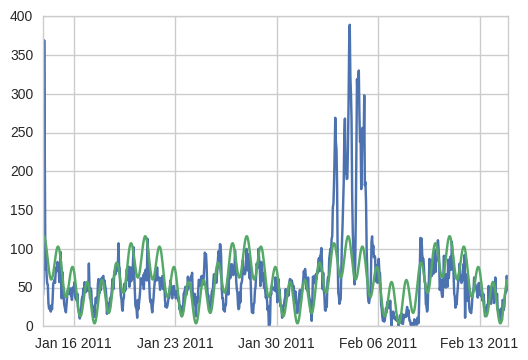

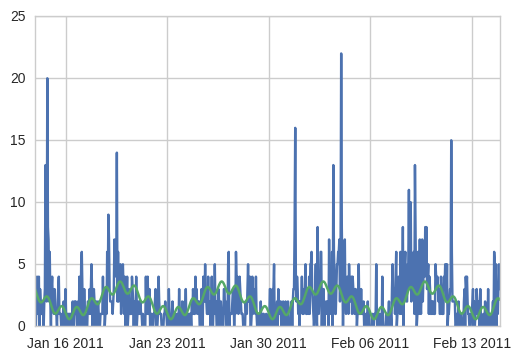

In [65]:
for df in [df_social, df_news]:
    
    df = df.set_index('date')
    h_counts = df.resample('H').size()
    t = (h_counts.index - h_counts.index[0]).total_seconds()
    y = h_counts.values    
    timestamps = (df.index - df.index[0]).total_seconds()
    start_time = df.index[0].to_datetime64()
    base_intensity.init_params([(tt, None, None) for tt in timestamps], run_times=10, normalize=False)
    
    print base_intensity
    
    plt.figure()
    plt.plot(start_time + np.timedelta64(1, 's') * t, y, label='true')
    plt.plot(start_time + np.timedelta64(1, 's') * t, base_intensity.eval(t), label='fit')

# Fit one week data



In [3]:
# prepare the data
start_date = min(df_social.date.iloc[0], df_news.date.iloc[0]).to_datetime64()
end_date = np.datetime64('2011-01-23')
dim_names = ['tweet', 'news']

events = []
for s, df in enumerate([df_social, df_news]):
    for i in range(len(df[df.date < end_date])):
        date, bow = df.iloc[i][['date', 'bow']]
        date = (date - start_date) / np.timedelta64(1, 's')
        events.append((date, s, bow))

In [4]:
events = sorted(events, key=lambda x: x[0])

## Single Kernel

In [73]:
np.random.seed(0)

n_dimensions = 2
dim_names = ['tweet', 'news']
n_features = len(vectorizer.vocabulary_)
scale = np.diff([e[0] for e in events if e[1] == 0]).mean()


config = {
    'base_intensities' : [SineBaseIntensity(1, [3600 * 24]), 
                          SineBaseIntensity(1, [3600 * 24])], 
    'base_intensity_weights' : None,
    'influential_matrix' : np.zeros((n_dimensions, n_dimensions)),
    'kernel' : ExponentialKernel(scale=scale),
    'impact_function' : ConstantImpactFunction(),        
    'mark_density' : TextualMarkDensity(n_features, lengths=[None, None], feature_probs=None, weight=None)
}

model = SourceIdentifyModel(n_dimensions, **config)

In [ ]:
model.fit(data=events, verbose=True)

  2%|▏         | 2/100 [05:12<4:15:47, 156.60s/it]    | 1/100 [02:36<4:19:00, 156.97s/it]

In [ ]:
for scale in [60, 120, 300, 600, 3600, 7200]:
    print "fitting the model with scale=", scale, "..."
    config['kernel'].scale = scale
    model = SourceIdentifyModel(n_dimensions, **config).fit(data=events, verbose=True)    
    path = '%s/model_scale=%d.pkl' % (output_folder, scale)
    model.save(path)
    model.load(path)               

# Different Kernels

In [10]:
np.random.seed(0)

n_dimensions = 2
dim_names = ['tweet', 'news']
n_features = len(vectorizer.vocabulary_)
scale = np.diff([e[0] for e in events if e[1] == 0]).mean()

config = {
    'base_intensities' : [SineBaseIntensity(1, [3600 * 24]), 
                          SineBaseIntensity(1, [3600 * 24])], 
    'base_intensity_weights' : None,
    'influential_matrix' : np.zeros((n_dimensions, n_dimensions)),
    'kernels' : [ExponentialKernel(scale=1),
                 ExponentialKernel(scale=1)],
    'impact_function' : ConstantImpactFunction(),        
    'mark_density' : TextualMarkDensity(n_features, lengths=[None, None], feature_probs=None, weight=None)
}

In [22]:
for scale1 in [60, 120, 300]:
    for scale2 in [1800, 3600, 9000]:
        print "fitting the model with scale1=%d, scale2=%d..." %(scale1, scale2)
        path = '%s/model_scale1=%d_scale2=%d.pkl' % (output_folder, scale1, scale2)
        if os.path.exists(path):
            continue
        
        config['kernels'][0].scale = scale1
        config['kernels'][1].scale = scale2
        
        model = SourceIdentifyModel(n_dimensions, **config).fit(data=events, verbose=True)    
        
        model.save(path)
        model.load(path)  

fitting the model with scale1=60, scale2=1800...
fitting the model with scale1=60, scale2=3600...



  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/s/python-2.7.12/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/u/z/h/zhangwei/.local/lib/python2.7/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/s/python-2.7.12/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  1%|          | 1/100 [04:17<7:04:53, 257.51s/it]

iter=1,	obj=-2.00466e+06



  2%|▏         | 2/100 [08:33<6:59:57, 257.12s/it]

iter=2,	obj=-1.51214e+06



  3%|▎         | 3/100 [12:48<6:54:36, 256.46s/it]

iter=3,	obj=-1.49574e+06



  4%|▍         | 4/100 [17:03<6:49:21, 255.85s/it]

iter=4,	obj=-1.48158e+06



  5%|▌         | 5/100 [21:17<6:44:37, 255.55s/it]

iter=5,	obj=-1.4765e+06



  6%|▌         | 6/100 [25:31<6:39:34, 255.05s/it]

iter=6,	obj=-1.47555e+06


iter=7,	obj=-1.47554e+06


fitting the model with scale1=60, scale2=9000...


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [07:34<12:29:48, 454.43s/it]

iter=1,	obj=-2.42465e+06


  2%|▏         | 2/100 [15:09<12:22:31, 454.61s/it]

iter=2,	obj=-1.50793e+06


  3%|▎         | 3/100 [22:43<12:14:32, 454.36s/it]

iter=3,	obj=-1.49311e+06


  4%|▍         | 4/100 [30:17<12:06:51, 454.28s/it]

iter=4,	obj=-1.47828e+06


  5%|▌         | 5/100 [37:49<11:58:22, 453.71s/it]

iter=5,	obj=-1.47231e+06


  6%|▌         | 6/100 [45:21<11:49:47, 453.06s/it]

iter=6,	obj=-1.47099e+06
iter=7,	obj=-1.47091e+06


fitting the model with scale1=120, scale2=1800...


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [04:22<7:13:08, 262.51s/it]

iter=1,	obj=-2.0273e+06


  2%|▏         | 2/100 [08:45<7:08:46, 262.52s/it]

iter=2,	obj=-1.51375e+06


  3%|▎         | 3/100 [13:07<7:04:12, 262.40s/it]

iter=3,	obj=-1.49994e+06


  4%|▍         | 4/100 [17:29<6:59:37, 262.27s/it]

iter=4,	obj=-1.48447e+06


  5%|▌         | 5/100 [21:51<6:55:05, 262.17s/it]

iter=5,	obj=-1.47684e+06


  6%|▌         | 6/100 [26:12<6:50:13, 261.85s/it]

iter=6,	obj=-1.47485e+06


  7%|▋         | 7/100 [30:33<6:45:26, 261.57s/it]

iter=7,	obj=-1.47465e+06
iter=8,	obj=-1.47466e+06
fitting the model with scale1=120, scale2=3600...



  1%|          | 1/100 [05:35<9:12:51, 335.07s/it]

iter=1,	obj=-2.1776e+06


  2%|▏         | 2/100 [11:09<9:07:09, 334.99s/it]

iter=2,	obj=-1.50835e+06


  3%|▎         | 3/100 [16:43<9:00:56, 334.60s/it]

iter=3,	obj=-1.49408e+06


  4%|▍         | 4/100 [22:17<8:55:13, 334.52s/it]

iter=4,	obj=-1.47845e+06


  5%|▌         | 5/100 [27:52<8:49:32, 334.45s/it]

iter=5,	obj=-1.47123e+06


  6%|▌         | 6/100 [33:25<8:43:33, 334.19s/it]

iter=6,	obj=-1.46946e+06


  7%|▋         | 7/100 [38:58<8:37:17, 333.73s/it]

iter=7,	obj=-1.46931e+06
iter=8,	obj=-1.46932e+06


fitting the model with scale1=120, scale2=9000...


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [08:54<14:41:27, 534.22s/it]

iter=1,	obj=-2.59824e+06


  2%|▏         | 2/100 [17:46<14:31:47, 533.75s/it]

iter=2,	obj=-1.50293e+06


  3%|▎         | 3/100 [26:38<14:21:54, 533.14s/it]

iter=3,	obj=-1.48966e+06


  4%|▍         | 4/100 [35:32<14:13:17, 533.30s/it]

iter=4,	obj=-1.47418e+06


  5%|▌         | 5/100 [44:23<14:03:33, 532.77s/it]

iter=5,	obj=-1.46681e+06


  6%|▌         | 6/100 [53:13<13:53:25, 531.97s/it]

iter=6,	obj=-1.46488e+06


  7%|▋         | 7/100 [1:02:04<13:43:44, 531.44s/it]

iter=7,	obj=-1.4647e+06
iter=8,	obj=-1.46472e+06


fitting the model with scale1=300, scale2=1800...


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [08:08<13:25:30, 488.18s/it]

iter=1,	obj=-2.52214e+06


  2%|▏         | 2/100 [16:18<13:18:12, 488.70s/it]

iter=2,	obj=-1.50852e+06


  3%|▎         | 3/100 [24:26<13:10:09, 488.76s/it]

iter=3,	obj=-1.49869e+06


  4%|▍         | 4/100 [32:33<13:01:09, 488.22s/it]

iter=4,	obj=-1.48402e+06


  5%|▌         | 5/100 [40:41<12:52:54, 488.15s/it]

iter=5,	obj=-1.47268e+06


  6%|▌         | 6/100 [48:49<12:44:20, 487.88s/it]

iter=6,	obj=-1.46815e+06


  7%|▋         | 7/100 [56:55<12:35:20, 487.32s/it]

iter=7,	obj=-1.4671e+06
iter=8,	obj=-1.46704e+06
fitting the model with scale1=300, scale2=3600...



  1%|          | 1/100 [09:19<15:23:26, 559.66s/it]

iter=1,	obj=-2.67377e+06


  2%|▏         | 2/100 [18:37<15:13:16, 559.14s/it]

iter=2,	obj=-1.50274e+06


  3%|▎         | 3/100 [27:58<15:04:40, 559.59s/it]

iter=3,	obj=-1.49222e+06


  4%|▍         | 4/100 [37:17<14:55:10, 559.48s/it]

iter=4,	obj=-1.47675e+06


  5%|▌         | 5/100 [46:35<14:45:21, 559.18s/it]

iter=5,	obj=-1.4662e+06


  6%|▌         | 6/100 [55:53<14:35:16, 558.69s/it]

iter=6,	obj=-1.46249e+06


  7%|▋         | 7/100 [1:05:08<14:24:20, 557.64s/it]

iter=7,	obj=-1.46172e+06
iter=8,	obj=-1.4617e+06


fitting the model with scale1=300, scale2=9000...


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [12:39<20:52:37, 759.17s/it]

iter=1,	obj=-3.09548e+06


  2%|▏         | 2/100 [25:20<20:40:50, 759.70s/it]

iter=2,	obj=-1.49632e+06


  3%|▎         | 3/100 [37:58<20:27:42, 759.41s/it]

iter=3,	obj=-1.48595e+06


  4%|▍         | 4/100 [50:38<20:15:20, 759.59s/it]

iter=4,	obj=-1.47063e+06


  5%|▌         | 5/100 [1:03:17<20:02:15, 759.32s/it]

iter=5,	obj=-1.46097e+06


  6%|▌         | 6/100 [1:15:53<19:48:02, 758.33s/it]

iter=6,	obj=-1.45776e+06


  7%|▋         | 7/100 [1:28:29<19:34:08, 757.51s/it]

iter=7,	obj=-1.45711e+06
iter=8,	obj=-1.4571e+06
